# TL;DR

Zarr Cloud native format in Earth Observation Application Packages.

## Application Package Overview

See https://github.com/eoap/zarr-cloud-native-format/releases for the latest Application Packages

### Producer Application Package

The workflow is based on one of the workflows of the https://github.com/eoap#mastering-earth-observation-application-packaging-with-cwl module extended to provide the temporal element.

The steps are:

1. **STAC API Discovery**: defines a STAC API search request and queries a STAC API endpoint returning a FeatureCollection
2. **SearchResults**: extracts the discovered STAC Items `self` href.
3. **Water bodies detection**: a sub-workflow that runs: 
  * **Cropping**: Crops Sentinel-2 imagery to the Area of Interest (AOI).
  * **Normalized Difference Water Index (NDWI)**: Computes NDWI to identify water bodies.
  * **Otsu Thresholding**: Applies Otsu's thresholding method to binarize NDWI values.
4. **Zarr dataset creation and STAC Metadata**: Converts the results into a Zarr dataset and generates the STAC Collection including [STAC Datacube Extension](https://stac-extensions.github.io/datacube/).



In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join("."))
sys.path.insert(0, module_path)

from helpers import WorkflowViewer
import cwl_loader
cwl_loader.logger.remove()
cwl_loader.logger.add(sys.stderr, level="INFO")


1

In [2]:
version = "0.3.0"
wf = WorkflowViewer.from_file(f"https://github.com/eoap/zarr-cloud-native-format/releases/download/{version}/app-water-bodies.{version}.cwl", "water-bodies")

#### Inputs

In [3]:
wf.display_inputs()

| Id | Type | Label | Doc |
| --- | --- | --- | --- |
| `stac_api_endpoint` | `https://raw.githubusercontent.com/eoap/schemas/main/experimental/api-endpoint.yaml#APIEndpoint` | STAC API endpoint | STAC API endpoint |
| `search_request` | `https://raw.githubusercontent.com/eoap/schemas/main/experimental/discovery.yaml#STACSearchSettings` | STAC search request | STAC search request |
| `bands` | `string[]` | bands used for the NDWI | bands used for the NDWI |


#### Steps

In [4]:
wf.display_steps()

| Id | Runs | Label | Doc |
| --- | --- | --- | --- |
| `discovery` | `#stac-client` | STAC API discovery | Discover STAC items from a STAC API endpoint based on a search request |
| `convert_search` | `#convert-search` | Convert Search | Convert Search results to get the item self hrefs and the area of interest |
| `water_bodies` | `#detect_water_body` | Water bodies detection | Water bodies detection based on NDWI and otsu threshold applied to each STAC item (sub-workflow) |
| `stac` | `#stac` | Create a STAC catalog with COG outputs | Create a STAC catalog with the detected water bodies COG outputs |
| `stac_zarr` | `#stac-zarr` | Create a STAC Catalog for the Zarr store | Create a STAC Catalog for the Zarr store from the STAC catalog with COG outputs |


#### Outputs

In [5]:
wf.display_outputs()


| Id | Type | Label | Doc |
| --- | --- | --- | --- |
| `zarr_stac_catalog` | `Directory` | None | None |
| `stac_catalog` | `Directory` | None | None |


#### Component diagram

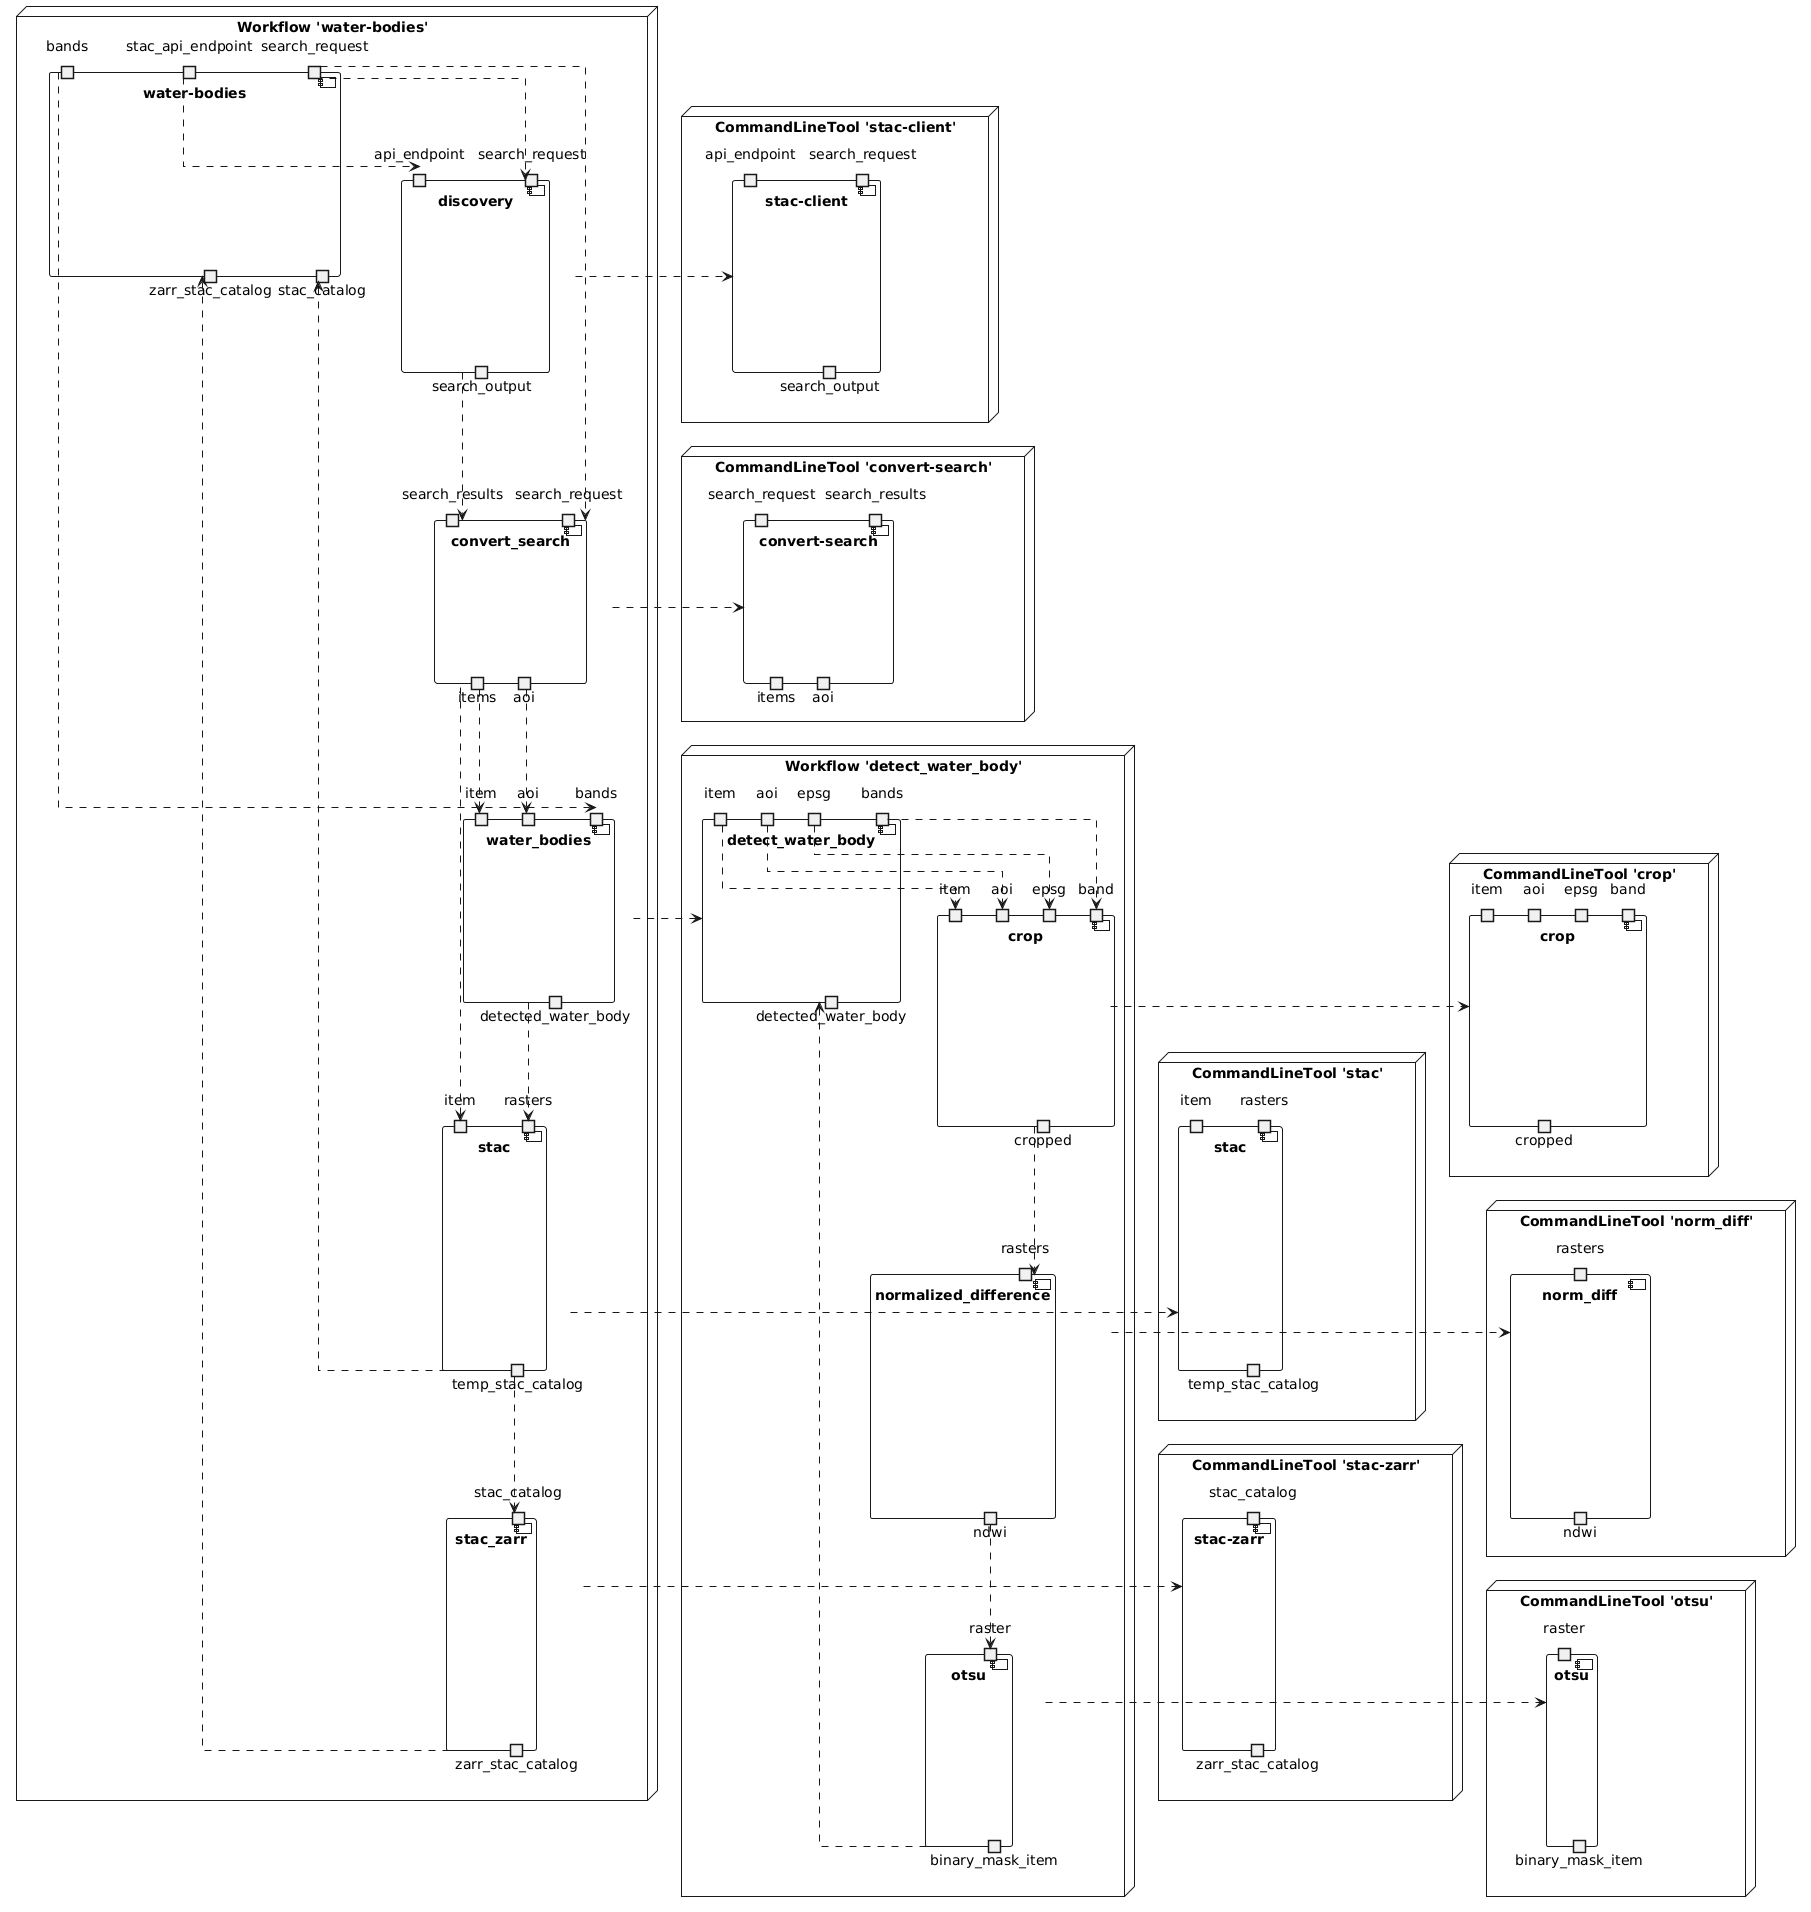

In [6]:
wf.display_components_diagram()

#### Class diagram

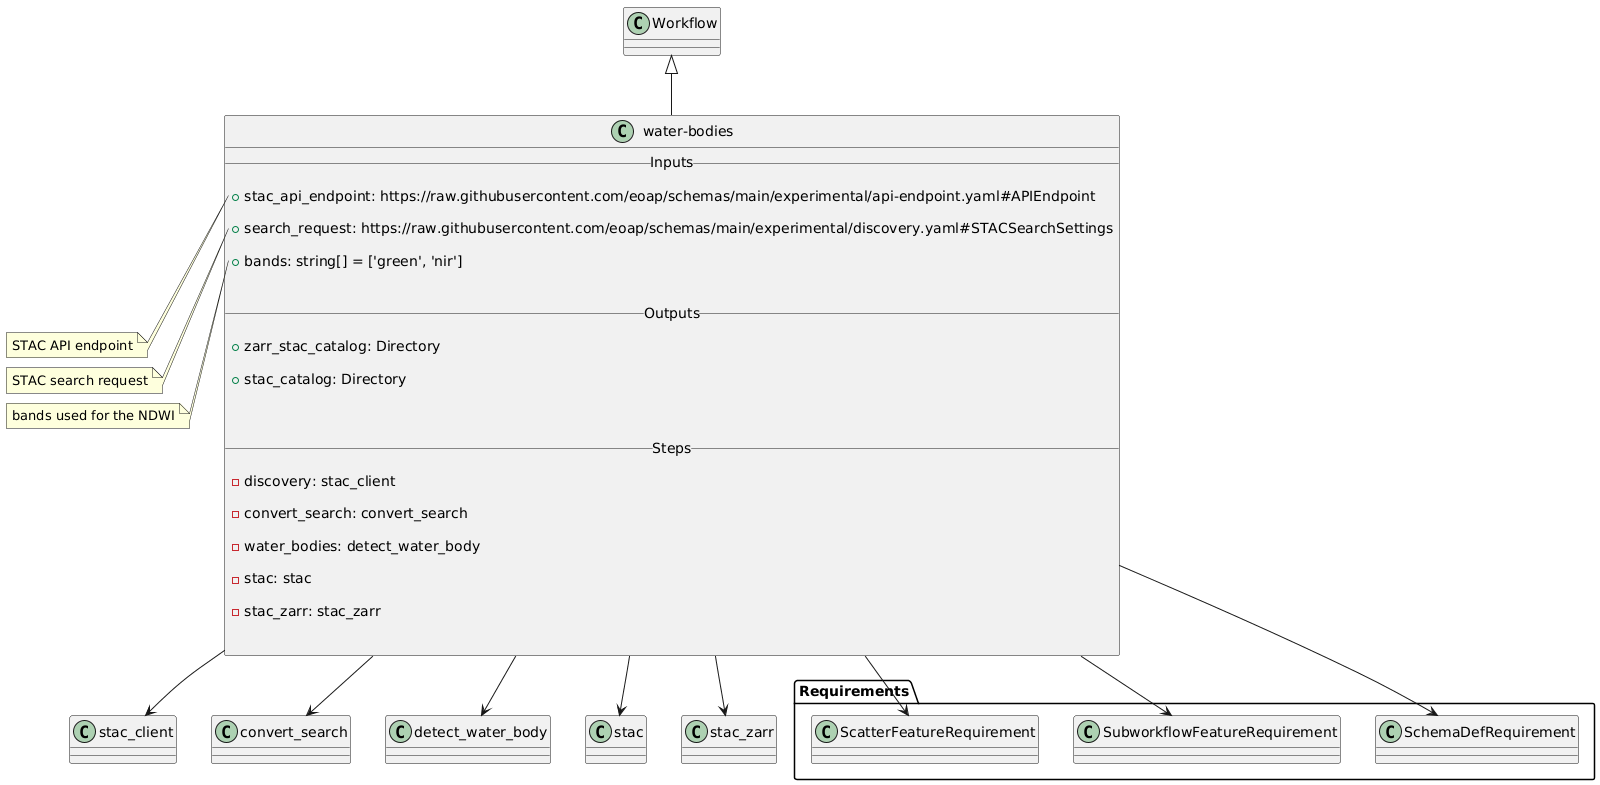

In [7]:
wf.display_class_diagram()

### Consumer Application Package

The workflow reads the produced STAC Catalog describing the detected water bodies Zarr store and produces the mean over the time dimension.

There's a single step that:

1. **Read STAC Catalog**: read the STAC Catalog and inspect the STAC Collection
2. **Read the Zarr store**: read the Zarr store STAC Asset
3. **mean calculation**: use `xarray` to calculate the mean over the time dimension
4. **export to GeoTIFF**: user `rioxarray` to write a GeoTIFF
5. **Generate STAC Catalog**: create a STAC Catalog describing the result



In [8]:
wf = WorkflowViewer.from_file(f"https://github.com/eoap/zarr-cloud-native-format/releases/download/{version}/app-water-bodies-occurrence.{version}.cwl", "water-bodies-occurrence")

#### Inputs

In [9]:
wf.display_inputs()

| Id | Type | Label | Doc |
| --- | --- | --- | --- |
| `zarr-stac-catalog` | `Directory` | Zarr store STAC Catalog | Input STAC catalog with datacube |


#### Steps

In [10]:
wf.display_steps()

| Id | Runs | Label | Doc |
| --- | --- | --- | --- |
| `step_occurrence` | `#occurrence` | Water bodies occurrence | Water bodies occurrence based on NDWI and otsu threshold |


#### Outputs

In [11]:
wf.display_outputs()


| Id | Type | Label | Doc |
| --- | --- | --- | --- |
| `stac-catalog` | `Directory` | STAC catalog | Output STAC catalog with water bodies occurrence |


#### Component diagram

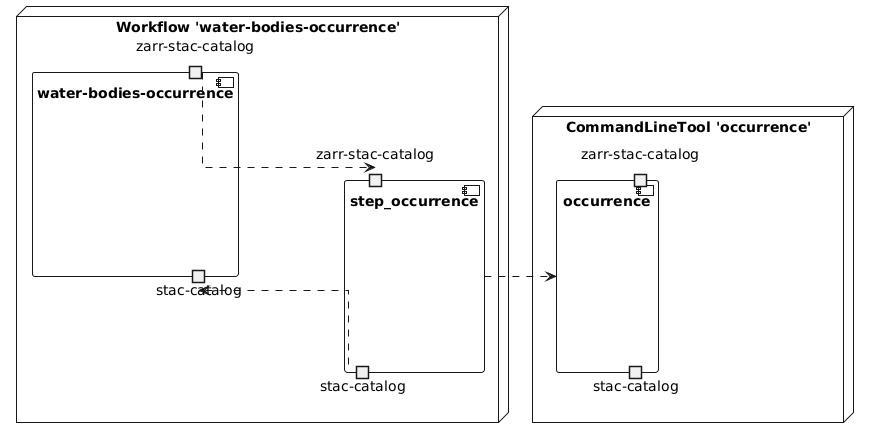

In [12]:
wf.display_components_diagram()

#### Class diagram

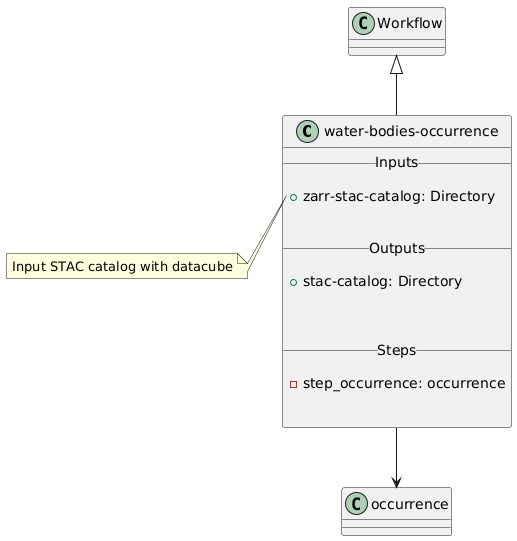

In [13]:
wf.display_class_diagram()

## Pre-requisites

To run this notebook, the pre-requisites are:

* A container runtime like `docker` or `podman`
* The `cwltool` CWL runner
* The Python libraries `shutil`, `pystac`, `xarray`, `rasterio` and `matplotlib`

## Part 1 - Zarr store producer: Application Package execution

Use `cwltool` to run the producer Application Package.



### Modules used

In [14]:
import yaml
from shutil import which
import nest_asyncio
from cwltool.main import main
from io import StringIO
import argparse
import json
nest_asyncio.apply()

### Container runtime

Check if `podman` or `docker` are available:

In [15]:
if which("podman"):
    podman = True
    print("Using podman")
elif which("docker"):
    podman = False
    print("Using docker")
else:
    raise ValueError("No container engine")

podman = False

Using podman


### Prepare the producer Application Package execution

Use `cwltool` and Python to execute the Application Package.

First create a YAML file with the parameters:



In [16]:
params = {}

params["bands"] = ["green", "nir"]

params["stac_api_endpoint"] = {
    "url": {"value": "https://earth-search.aws.element84.com/v1/"},
    "headers": [],
}

params["search_request"] = {
    "limit": 20,
    "collections": ["sentinel-2-l2a"],
    "datetime_interval": {
        "start": {"value": "2021-06-01T00:00:00"},
        "end": {"value": "2021-08-01T23:59:59"},
    },
    "bbox": [-121.399, 39.834, -120.74, 40.472],
    "max-items": 10
}

with open("producer-params.yaml", "w") as file:
    print(yaml.dump(params), file=file)

In [17]:
print(yaml.dump(params))

bands:
- green
- nir
search_request:
  bbox:
  - -121.399
  - 39.834
  - -120.74
  - 40.472
  collections:
  - sentinel-2-l2a
  datetime_interval:
    end:
      value: '2021-08-01T23:59:59'
    start:
      value: '2021-06-01T00:00:00'
  limit: 20
  max-items: 10
stac_api_endpoint:
  headers: []
  url:
    value: https://earth-search.aws.element84.com/v1/



### Producer Application Package execution

We use the released application package available here https://github.com/eoap/zarr-cloud-native-format/releases and cwltool APIs to run the Application Package.

Any error messages such as:

`Error: No such object: ghcr.io/eoap/zarr-cloud-native-format/stac-zarr@sha256:72fdc2757ace393b3d94995bd3e300e0f32c6a3906fe5e659f8a9efb95de76ea`

is a not a real error, it's just that the container image isn't available locally and must be pulled.

In [18]:
parsed_args = argparse.Namespace(
    podman=podman,
    parallel=False,
    validate=False,
    debug=False,
    outdir="./runs",
    quiet=True,
    workflow=f"https://github.com/eoap/zarr-cloud-native-format/releases/download/{version}/app-water-bodies.{version}.cwl#water-bodies",
    job_order=["producer-params.yaml"],
)

stream_out = StringIO()
stream_err = StringIO()

res = main(
    args=parsed_args,
    stdout=stream_out,
    stderr=stream_err,
)

assert res == 0

Error: No such object: ghcr.io/eoap/zarr-cloud-native-format/stac-zarr@sha256:5d3522f67b6ee73276563e01b436772161fd8e1658149e38e64615d296170692


The `stream_out` object contains the cwltool stdout.

We can list the results keys with:

In [19]:
producer_results = json.loads(stream_out.getvalue())

list(producer_results.keys())

['zarr_stac_catalog', 'stac_catalog']

And find the path of the directory containing the STAC Catalog with the Zarr store:

In [20]:
producer_results["zarr_stac_catalog"]["path"]

'/data/work/github/eoap/zarr-cloud-native-format/docs/runs/zsmhv_g9'

## Part 2 - Inspect Application Package results

Read the STAC Catalog containing the Zarr store

### Modules

In [21]:
import pystac
import os
from pystac.extensions.datacube import DatacubeExtension


### Inspect the STAC Collection metadata

Open the STAC Catalog generated as an output of the producer Application Package execution:

In [22]:
cat = pystac.Catalog.from_file(
    os.path.join(
        producer_results["zarr_stac_catalog"]["path"], "catalog.json"
    )
)

In [23]:
cat.describe()

* <Catalog id=water-bodies>
    * <Collection id=water-bodies>


Now open the STAC Collection named `water-bodies`:

In [24]:
collection = cat.get_child("water-bodies")

collection.describe()

* <Collection id=water-bodies>


In [25]:
collection

<Collection id=water-bodies>

The STAC Collection contains an asset:

In [26]:
zarr_asset = collection.get_assets()["data"]

print(f"Zarr asset media type: {zarr_asset.media_type}")

zarr_asset

Zarr asset media type: application/vnd+zarr


<Asset href=result.zarr>

Inspect the datacube extension metadata included in the STAC Collection:

In [27]:
dc_collection = DatacubeExtension.ext(collection)

* List and describe the dimensions

In [28]:
for key, value in dc_collection.dimensions.items():

    print(key, dc_collection.dimensions[key].to_dict())

x {'type': 'spatial', 'axis': 'x', 'extent': [636995.0, 691585.0], 'reference_system': 'epsg:32610', 'description': 'X coordinate of projection'}
y {'type': 'spatial', 'axis': 'y', 'extent': [4410555.0, 4482595.0], 'reference_system': 'epsg:32610', 'description': 'Y coordinate of projection'}
time {'type': 'temporal', 'extent': ['2021-06-28T19:03:24.330000000', '2021-07-28T19:03:25.963000000'], 'description': 'Time dimension'}


* List and describe the variables

In [29]:
for key, value in dc_collection.variables.items():
    print(key, dc_collection.variables[key].to_dict())

data {'type': 'data', 'name': 'water-bodies', 'description': 'detected water bodies', 'dimensions': ['y', 'x', 'time'], 'chunks': [512, 512, 1]}


In [30]:
dc_collection.variables["data"].to_dict()

{'type': 'data',
 'name': 'water-bodies',
 'description': 'detected water bodies',
 'dimensions': ['y', 'x', 'time'],
 'chunks': [512, 512, 1]}

## Part 3 - Inspect the zarr store

Open the Zarr store with `xarray` to access its metadata and data.

### Modules

In [31]:
import xarray as xr

In [32]:
zarr_asset.extra_fields["xarray:open_kwargs"]

{'consolidated': True}

### Open the Zarr result with xarray

In [33]:
water_bodies = xr.open_zarr(zarr_asset.get_absolute_href(), **zarr_asset.extra_fields["xarray:open_kwargs"])


In [34]:
xr.set_options(display_style="text")

water_bodies

<xarray.Dataset> Size: 315MB
Dimensions:      (time: 8, y: 7205, x: 5460)
Coordinates:
  * time         (time) datetime64[ns] 64B 2021-06-28T19:03:24.330000 ... 202...
  * x            (x) float64 44kB 6.37e+05 6.37e+05 ... 6.916e+05 6.916e+05
  * y            (y) float64 58kB 4.483e+06 4.483e+06 ... 4.411e+06 4.411e+06
Data variables:
    data         (time, y, x) uint8 315MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    spatial_ref  int32 4B ...

Inspect the data variable:

In [35]:
water_bodies.data

<xarray.DataArray 'data' (time: 8, y: 7205, x: 5460)> Size: 315MB
dask.array<open_dataset-data, shape=(8, 7205, 5460), dtype=uint8, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 64B 2021-06-28T19:03:24.330000 ... 2021-07...
  * x        (x) float64 44kB 6.37e+05 6.37e+05 6.37e+05 ... 6.916e+05 6.916e+05
  * y        (y) float64 58kB 4.483e+06 4.483e+06 ... 4.411e+06 4.411e+06
Attributes:
    grid_mapping:  spatial_ref
    nodata:        0.0

* Check the geospatial metadata

In [36]:
water_bodies.data_vars["spatial_ref"]

<xarray.DataArray 'spatial_ref' ()> Size: 4B
[1 values with dtype=int32]
Attributes: (12/18)
    GeoTransform:                      636990 10 0 4482600 0 -10
    crs_wkt:                           PROJCRS["WGS 84 / UTM zone 10N",BASEGE...
    false_easting:                     500000.0
    false_northing:                    0.0
    geographic_crs_name:               WGS 84
    grid_mapping_name:                 transverse_mercator
    ...                                ...
    projected_crs_name:                WGS 84 / UTM zone 10N
    reference_ellipsoid_name:          WGS 84
    scale_factor_at_central_meridian:  0.9996
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    spatial_ref:                       PROJCRS["WGS 84 / UTM zone 10N",BASEGE...

In [37]:
str(water_bodies.data_vars["spatial_ref"].values)

'32610'

* Inspect the Zarr coordinates

In [38]:
water_bodies.coords

Coordinates:
  * time     (time) datetime64[ns] 64B 2021-06-28T19:03:24.330000 ... 2021-07...
  * x        (x) float64 44kB 6.37e+05 6.37e+05 6.37e+05 ... 6.916e+05 6.916e+05
  * y        (y) float64 58kB 4.483e+06 4.483e+06 ... 4.411e+06 4.411e+06

* List the values of the `time` coordinate:

In [39]:
water_bodies.coords["time"].values

array(['2021-06-28T19:03:24.330000000', '2021-07-08T19:03:25.409000000',
       '2021-07-08T19:03:25.410000000', '2021-07-13T19:03:24.627000000',
       '2021-07-18T19:03:25.940000000', '2021-07-23T19:03:24.661000000',
       '2021-07-28T19:03:25.962000000', '2021-07-28T19:03:25.963000000'],
      dtype='datetime64[ns]')

* Plot the water bodies detected on '2021-07-13T19:03:24.000000000'

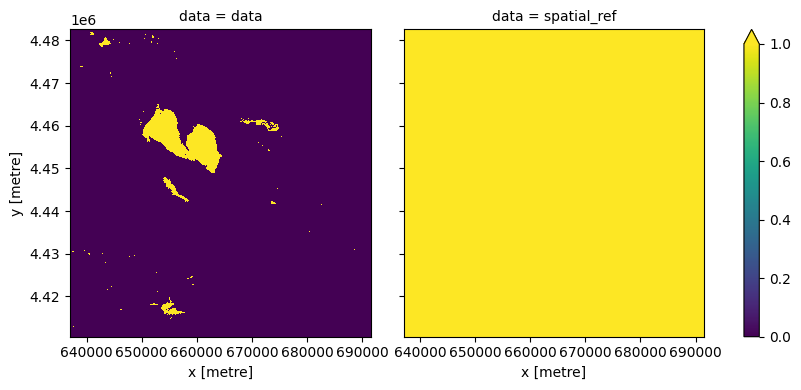

In [40]:
_ = (
    water_bodies.isel(time=1)
    .to_array("data")
    .plot.imshow(
        col="data",
        size=4,
        vmin=0,
        vmax=1,
    )
)

## Part 4 - Consume the Zarr store using the consumer Application Package

**Goal: Invoke an Application Package that consumes the detected water bodies Zarr store.**

### Run the consumer Application Package

First, create a YAML file with the parameters: the path to the STAC Catalog describing the detected water bodies Zarr store.

In [41]:
consumer_params = {}

consumer_params["zarr-stac-catalog"] = {
  "class": "Directory",
  "path": producer_results["zarr_stac_catalog"]["path"]
}

with open("consumer-params.yaml", "w") as file:
    print(yaml.dump(consumer_params), file=file)

print(yaml.dump(consumer_params))

zarr-stac-catalog:
  class: Directory
  path: /data/work/github/eoap/zarr-cloud-native-format/docs/runs/zsmhv_g9



Now, use `cwltool` APIs to run the consumer Application Package.

Again, any error messages such as:

`Error: No such object: ghcr.io/eoap/zarr-cloud-native-format/occurrence@sha256:256f8672ff74f41b97ab307162b09e07412eddd1d9658a07106379597a7c9fad`

is a not a real error, it's just that the container image isn't available locally and must be pulled.

In [42]:
version = "0.3.0"

parsed_args = argparse.Namespace(
    podman=podman,
    parallel=False,
    validate=False,
    debug=False,
    outdir="./runs",
    quiet=True,
    workflow=f"https://github.com/eoap/zarr-cloud-native-format/releases/download/{version}/app-water-bodies-occurrence.{version}.cwl#water-bodies-occurrence",
    job_order=["consumer-params.yaml"],
)

stream_out = StringIO()
stream_err = StringIO()

res = main(
    args=parsed_args,
    stdout=stream_out,
    stderr=stream_err,
)

assert res == 0

Error: No such object: ghcr.io/eoap/zarr-cloud-native-format/occurrence@sha256:9a2b406bd5cb3bbdbbfd0f23fda48765b3c006e18d52429c8165392e032180d9


In [43]:
print(stream_err.getvalue())

WARNING [job step_occurrence] Skipping Docker software container '--memory' limit despite presence of ResourceRequirement with ramMin and/or ramMax setting. Consider running with --strict-memory-limit for increased portability assurance.
WARNING [job step_occurrence] Skipping Docker software container '--cpus' limit despite presence of ResourceRequirement with coresMin and/or coresMax setting. Consider running with --strict-cpu-limit for increased portability assurance.



### Inspect the generate STAC Catalog

The execution produces a STAC Catalog:

In [44]:
consumer_results = json.loads(stream_out.getvalue())

consumer_results["stac-catalog"]["path"]

'/data/work/github/eoap/zarr-cloud-native-format/docs/runs/b1kzcfx1'

In [45]:
occurence_cat = pystac.Catalog.from_file(
    os.path.join(
        consumer_results["stac-catalog"]["path"], "catalog.json"
    )
)

The STAC Catalog contains a STAC Item:

In [46]:
occurence_cat.describe()

* <Catalog id=catalog>
  * <Item id=occurrence>


In [47]:
occurence_item = next(occurence_cat.get_all_items())

occurence_item

<Item id=occurrence>

### Plot the mean GeoTiff

Open the `data` STAC Asset and plot the GeoTiff:

In [48]:
occurence_item.get_assets()

{'data': <Asset href=./water_bodies_mean.tif>}

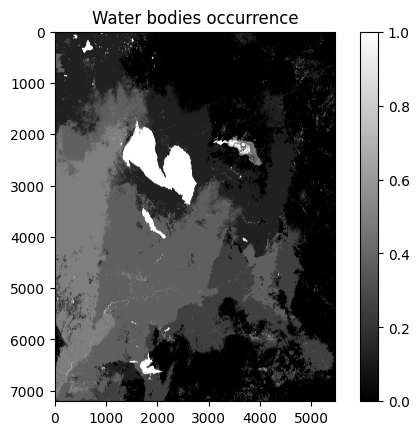

In [49]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open(occurence_item.get_assets()["data"].get_absolute_href()) as src:
    img = src.read(1)

plt.imshow(img, cmap="gray")
plt.colorbar()
plt.title("Water bodies occurrence")
plt.show()